# Nucleosome Free Region based analysis
Homer has a mechanism for detecting dips in H3K27Ac data signal - which for clean data are associated with nucleosome free regions. however, the data that we have for this project is limited by noise in the H3K27Ac signaling data

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

Set working directory

In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/SOX9/'
workingDirectory = '/home/h1bennet/brain_aging/results/03_Sox9_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Summary plots

In [4]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

Read in annotation files

In [5]:
# import annotation file
df, mat = read_annotated_peaks('./annotated_peaks/ann_norm_idr_nfr_peaks_merged.txt')

# # try with dropped sample
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks

In [6]:
mat.columns

Index(['/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/01_mouse_BL6_M_3week_SOX9_ChIP_H3K27ac_1_AL_l20200911_CATAGAGT_TGCCACCA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/01_mouse_BL6_M_3week_SOX9main_ChIP_H3K27ac_2_AL_l20200925_AGTACTCC_AACCTGTT',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA'],
      dtype='object')

In [7]:
thresh = 16

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

74460 total peaks
filtering low tag count peaks
67129 total peaks


### Mean variance plot

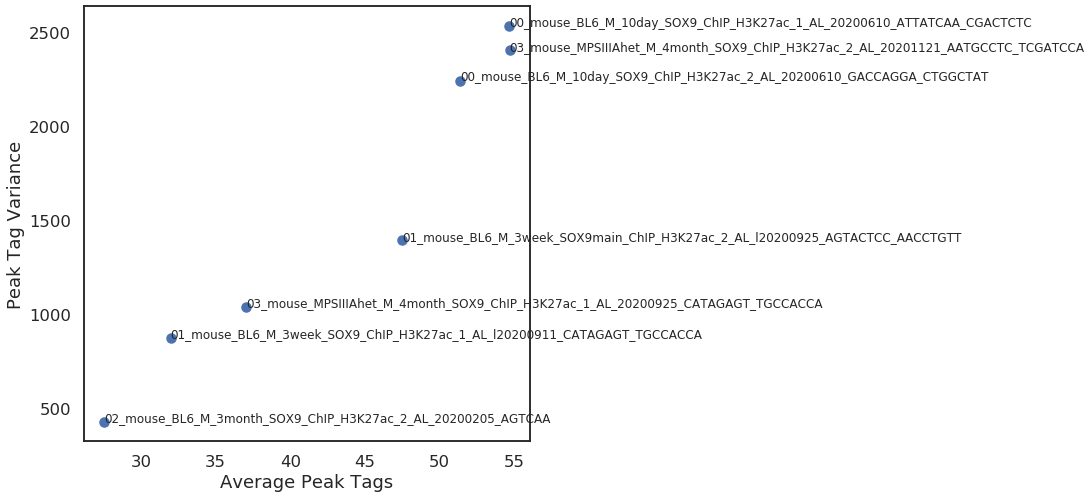

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/nfr_mean_variance_plot.png', bbox_inches='tight')

### Try with quantile normalized data

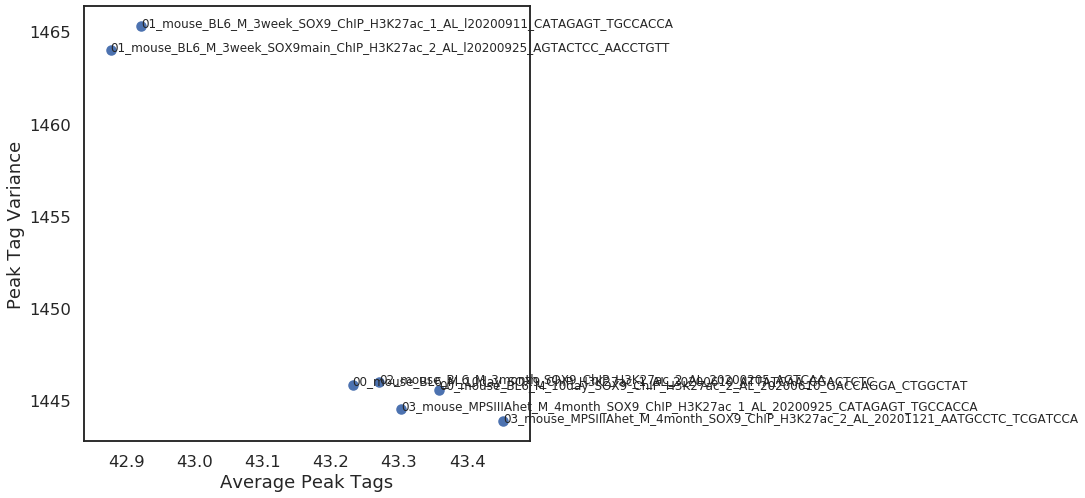

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/nfr_mean_variance_plot_quantnorm.png', bbox_inches='tight')

### Correlation heatmap

In [12]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

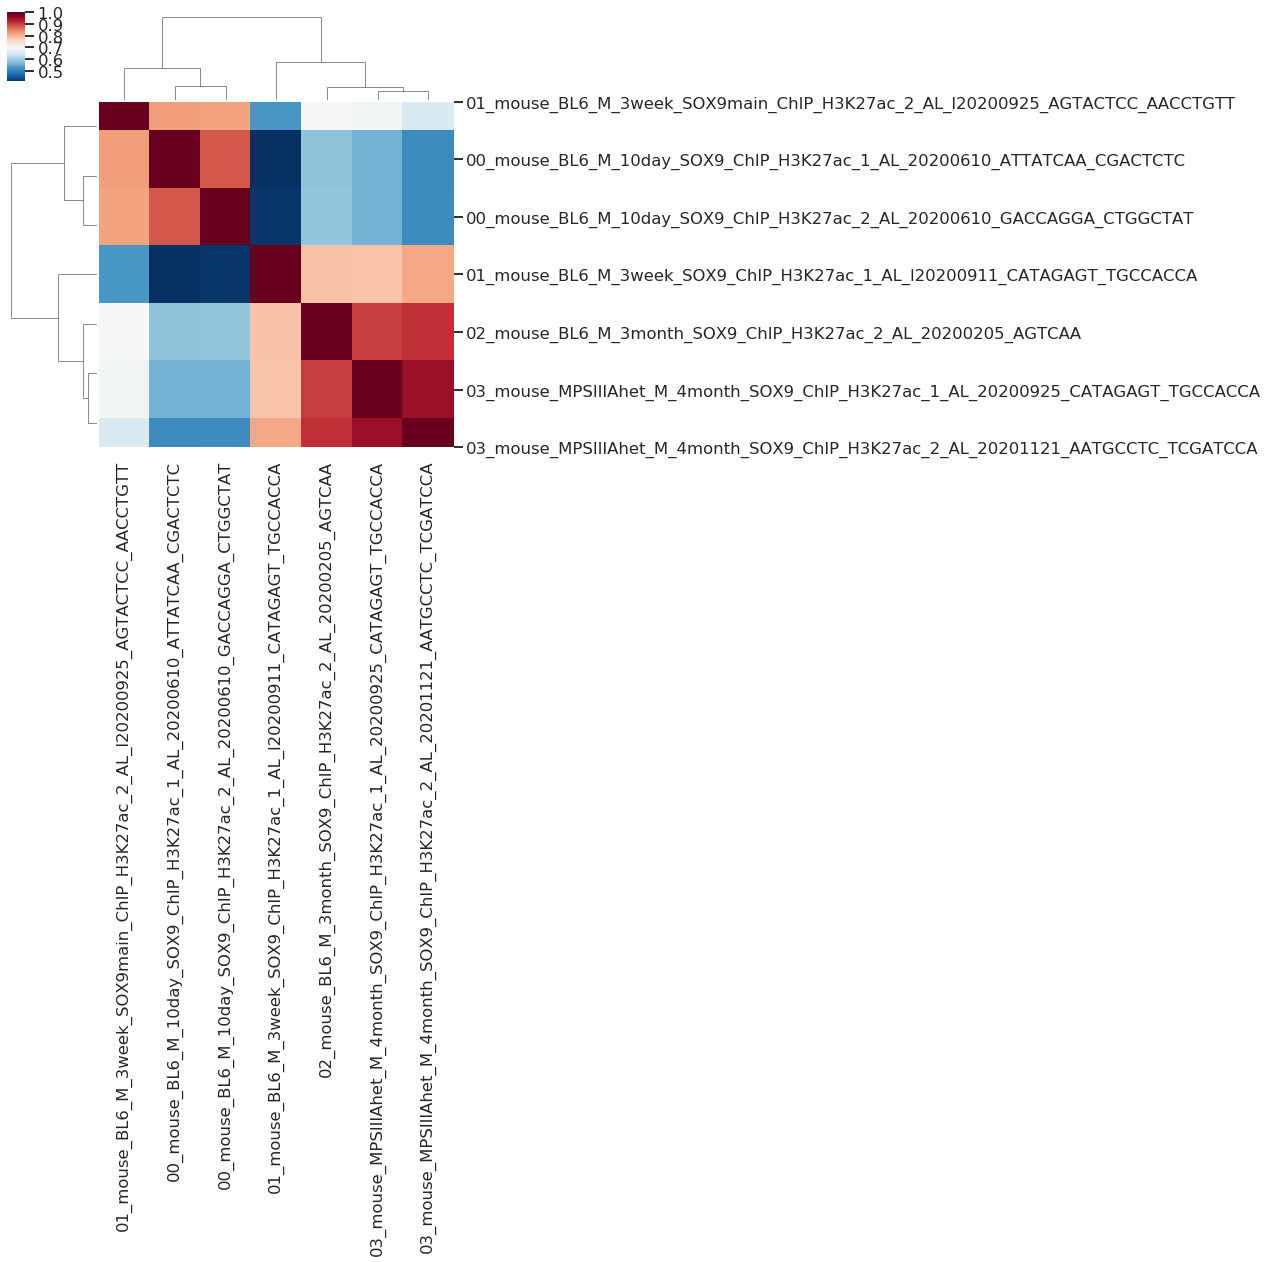

In [13]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/nfr_h3k27ac_correlation_heatmap.png', bbox_inches='tight')

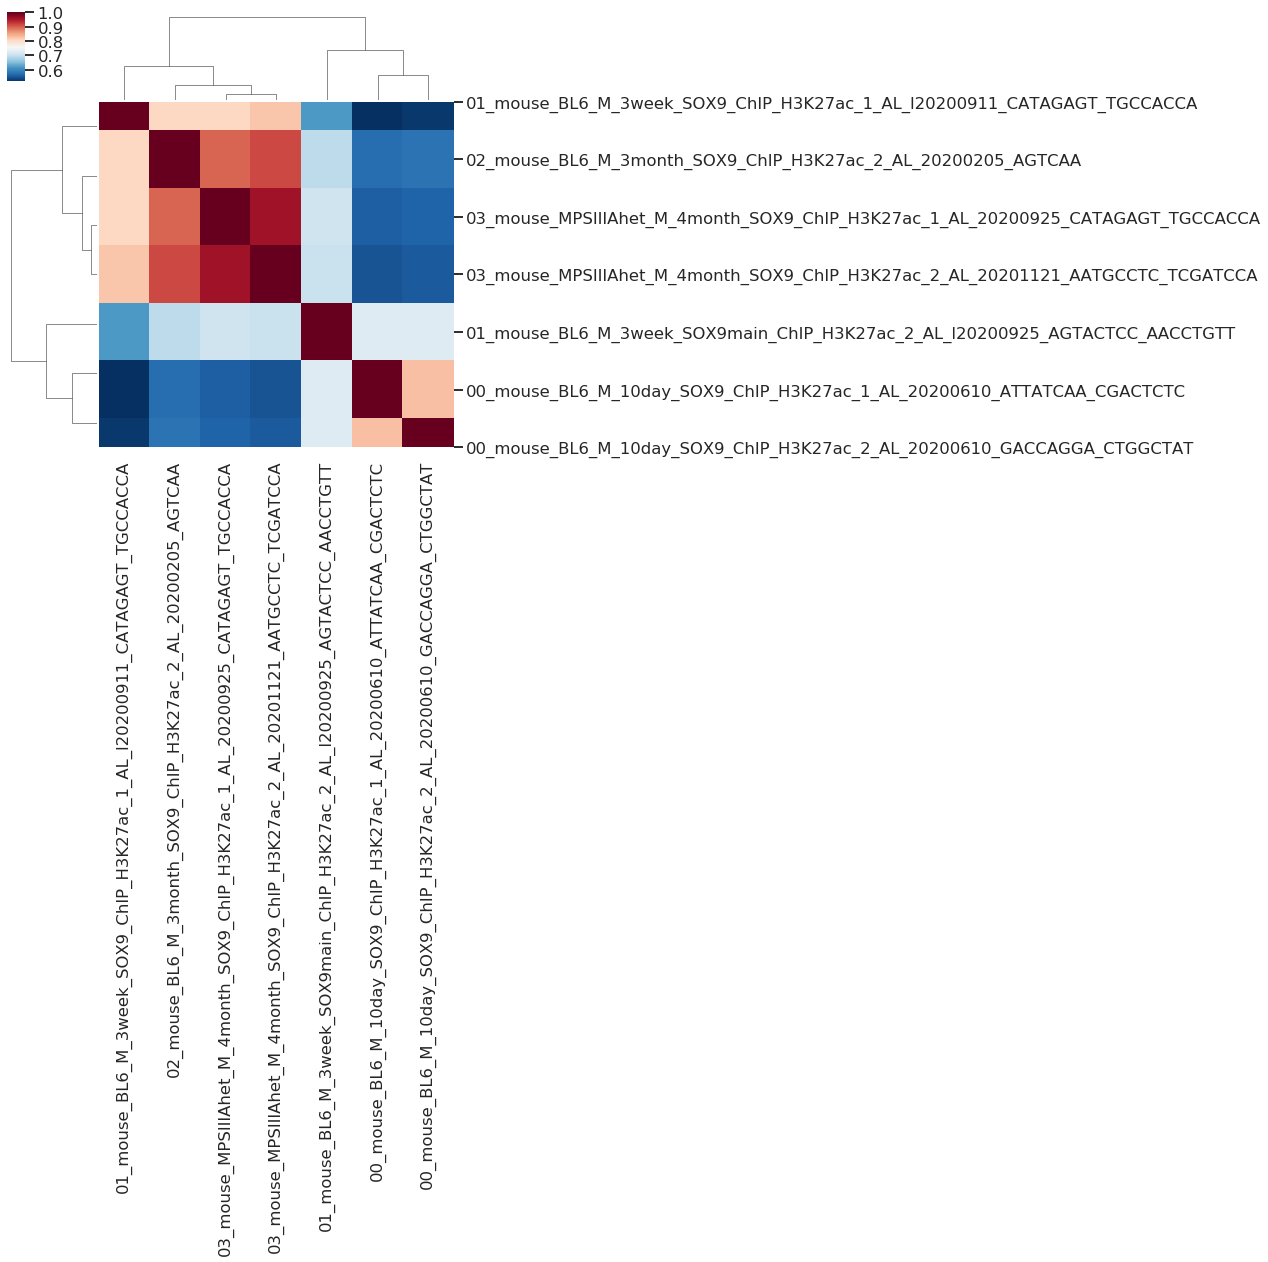

In [14]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/nfr_h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

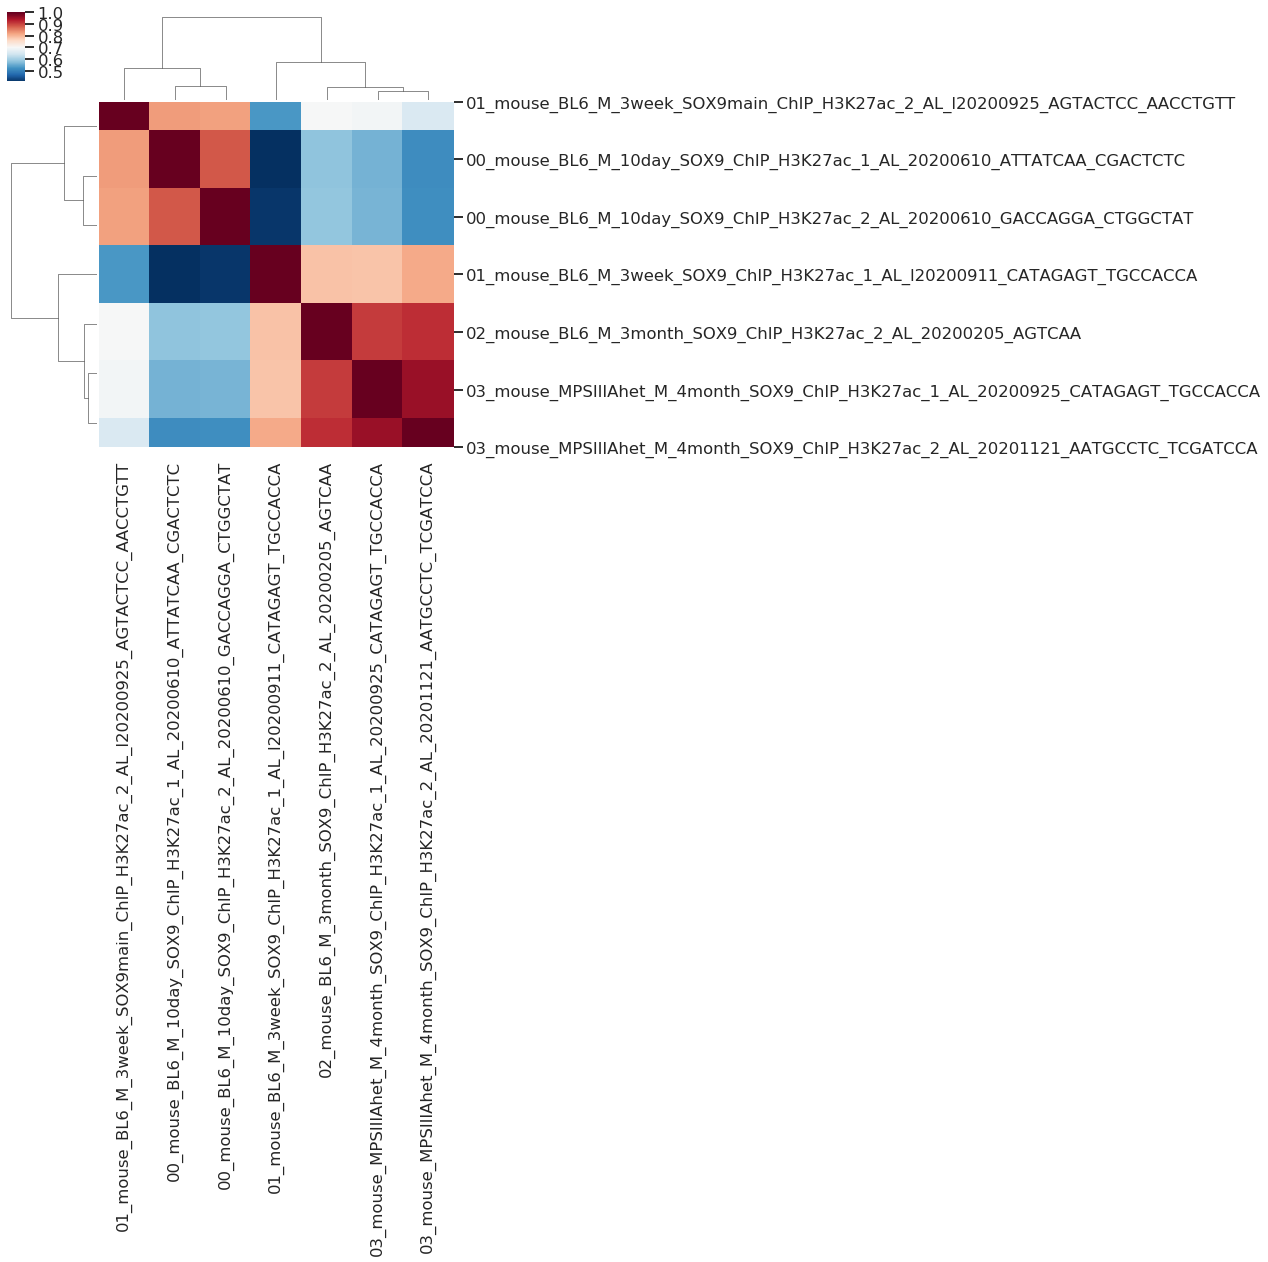

In [15]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/nfr_h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [16]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

In [17]:
samplesDF

,mouse,group,strain,gender,age,celltype,rep,sample_date
0,00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20...,00,BL6,M,10day,SOX9,1,AL
1,00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20...,00,BL6,M,10day,SOX9,2,AL
2,01_mouse_BL6_M_3week_SOX9_ChIP_H3K27ac_1_AL_l2...,01,BL6,M,3week,SOX9,1,AL
3,01_mouse_BL6_M_3week_SOX9main_ChIP_H3K27ac_2_A...,01,BL6,M,3week,SOX9main,2,AL
4,02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_2...,02,BL6,M,3month,SOX9,2,AL
5,03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac...,03,MPSIIIAhet,M,4month,SOX9,1,AL
6,03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac...,03,MPSIIIAhet,M,4month,SOX9,2,AL


### Look at PCA plots for all the samples

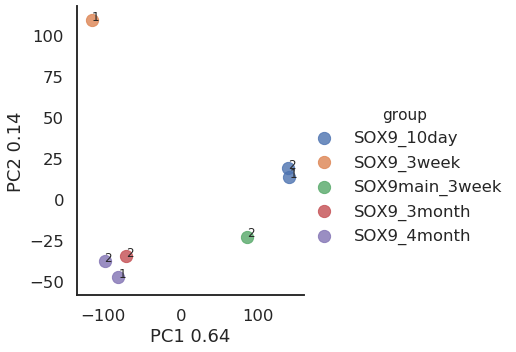

In [18]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/nfr_h3k27ac_pca1_pca2.png', bbox_inches='tight')

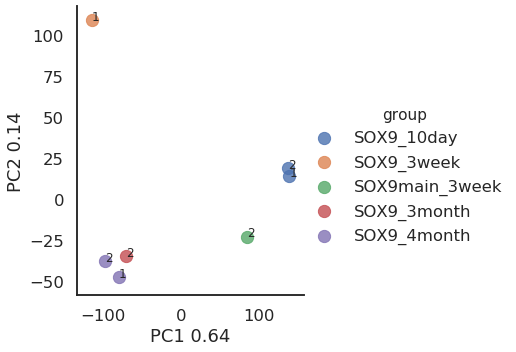

In [19]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/nfr_h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

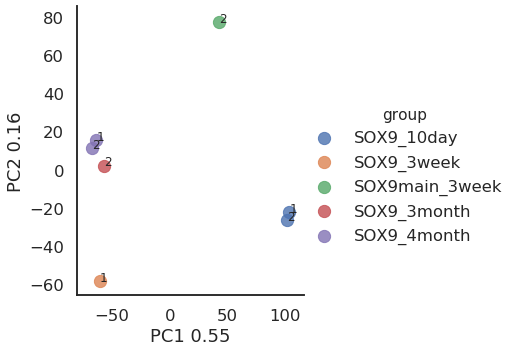

In [20]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/nfr_h3k27ac_distal_pca1_pca2.png', bbox_inches='tight')

# Plot average tag counts across peaks to assess differences

This part is sensitive to whether we include the 3 week sox9 data. it might be best to wait to do downstream analysis on this until we have deeper sequenced SOX9_10day data.

In [21]:
import itertools

## un-normalized peaks

In [22]:
mat.columns

Index(['00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC',
       '00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT',
       '01_mouse_BL6_M_3week_SOX9_ChIP_H3K27ac_1_AL_l20200911_CATAGAGT_TGCCACCA',
       '01_mouse_BL6_M_3week_SOX9main_ChIP_H3K27ac_2_AL_l20200925_AGTACTCC_AACCTGTT',
       '02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA'],
      dtype='object')

In [23]:
groups = ['Young', 'Old']
columns = [[0,1],
           [4,5,6]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


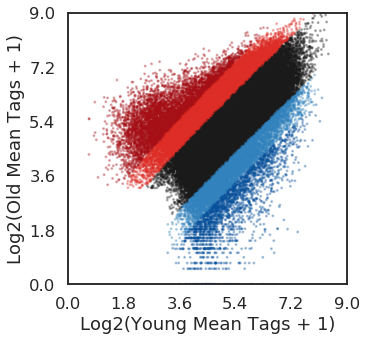

In [24]:
# set loop variables
mincount=8
thresh=[2,4]
thresh_color = {'down': ['#de2d26', '#a50f15'],
                'up': ['#3182bd', '#08519c']}
peak_count = {}

n_ticks = 5

for i, j in itertools.combinations(groups, 2):

    fig, ax = plt.subplots(figsize=(5,5))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    peak_count['up_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    peak_count['down_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    peak_count['up_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1]).sum()

    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]
    peak_count['down_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1]).sum()

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    
    # save plot
    plt.savefig('./figures/nfr_pairwise_scatter.png', bbox_inches='tight')

## Quantile normalized peaks

In [25]:
groups = ['Young', 'Old']
columns = [[0,1],
           [4,5,6]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat_quant.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


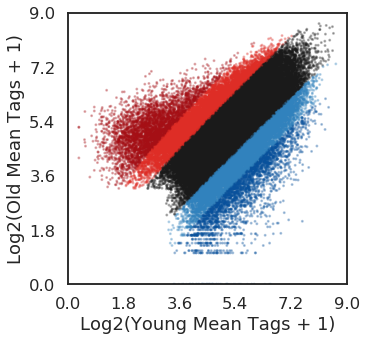

In [26]:
# set loop variables
mincount=8
thresh=[2,4]
thresh_color = {'down': ['#de2d26', '#a50f15'],
                'up': ['#3182bd', '#08519c']}
peak_count = {}

n_ticks = 5

for i, j in itertools.combinations(groups, 2):

    fig, ax = plt.subplots(figsize=(5,5))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    peak_count['up_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    peak_count['down_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    peak_count['up_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1]).sum()

    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]
    peak_count['down_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1]).sum()

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    
    # save plot
    plt.savefig('./figures/nfr_pairwise_scatter_quant_normalized.png', bbox_inches='tight')